In [236]:
import numpy as np
import cvxpy as cp
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [237]:
data = pd.read_csv('historical_returns.csv')

In [238]:
returns = data.drop('Date', axis=1)
expected_returns = returns.mean()
expected_returns_sorted = expected_returns.sort_values(ascending=False)
expected_returns_sorted

NVDA     0.005442
TSLA     0.003893
AMZN     0.002511
ADBE     0.002498
NFLX     0.002288
GOOGL    0.001990
MSFT     0.001972
AAPL     0.001835
V        0.000993
PYPL    -0.000513
dtype: float64

In [239]:
cov_matrix = returns.cov()
cov_matrix

,AAPL,ADBE,AMZN,GOOGL,MSFT,NFLX,NVDA,PYPL,TSLA,V
AAPL,0.000158,0.000133,0.000116,0.000127,0.000109,0.000125,0.000171,0.000122,0.000185,0.000060
ADBE,0.000133,0.000402,0.000222,0.000194,0.000184,0.000179,0.000332,0.000169,0.000259,0.000095
AMZN,0.000116,0.000222,0.000433,0.000239,0.000190,0.000183,0.000242,0.000150,0.000257,0.000064
GOOGL,0.000127,0.000194,0.000239,0.000367,0.000155,0.000146,0.000237,0.000158,0.000214,0.000059
MSFT,0.000109,0.000184,0.000190,0.000155,0.000250,0.000145,0.000260,0.000095,0.000167,0.000051
NFLX,0.000125,0.000179,0.000183,0.000146,0.000145,0.000561,0.000221,0.000134,0.000213,0.000068
NVDA,0.000171,0.000332,0.000242,0.000237,0.000260,0.000221,0.000932,0.000139,0.000413,0.000095
PYPL,0.000122,0.000169,0.000150,0.000158,0.000095,0.000134,0.000139,0.000526,0.000299,0.000071
TSLA,0.000185,0.000259,0.000257,0.000214,0.000167,0.000213,0.000413,0.000299,0.001100,0.000109
V,0.000060,0.000095,0.000064,0.000059,0.000051,0.000068,0.000095,0.000071,0.000109,0.000096


In [259]:
n = len(expected_returns)
w = cp.Variable(n)
expected_returns = np.array(expected_returns)
min_return = 0.003
portfolio_risk = cp.quad_form(w, cov_matrix)

In [260]:
portfolio_return = expected_returns @ w
constraints = [
    cp.sum(w) == 1,
    w >= 0,
    portfolio_return >= min_return
]

In [261]:
problem = cp.Problem(cp.Minimize(portfolio_risk), constraints)

In [262]:
problem.solve(solver=cp.OSQP)

0.00022942583191043855

In [263]:
formatted_weights = [f"{weight:.6f}" for weight in w.value]

In [264]:
optimal_weights = w.value
print("Optymalne wagi:", optimal_weights)
print("Oczekiwany zwrot:", portfolio_return.value)
print("Ryzyko portfela:", np.sqrt(portfolio_risk.value))

Optymalne wagi: [0.331942 0.000003 0.117078 -0.000013 -0.000007 0.044967 0.304048 0.000011
 0.048029 0.153941]
Oczekiwany zwrot: 0.003000425980174884
Ryzyko portfela: 0.015146809298015162


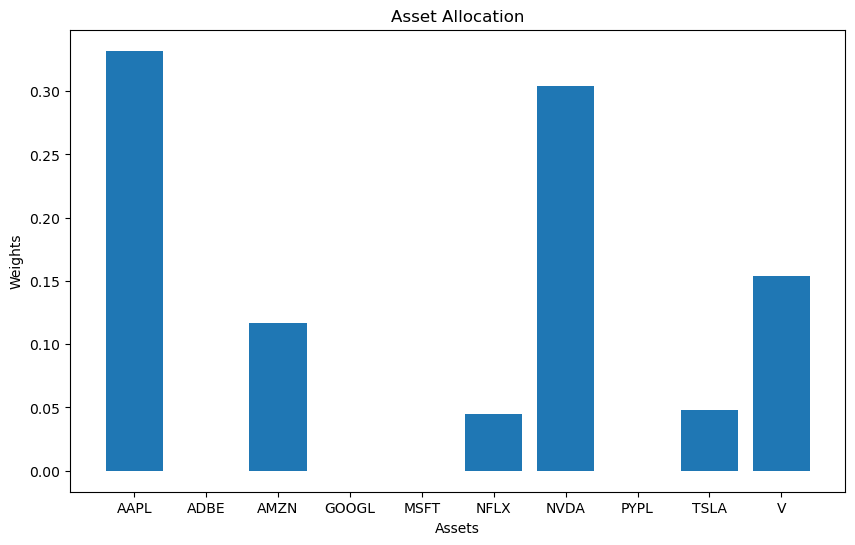

In [265]:
plt.figure(figsize=(10, 6))
plt.bar(returns.columns, optimal_weights)
plt.xlabel('Assets')
plt.ylabel('Weights')
plt.title('Asset Allocation')
plt.show()

In [268]:
target_variances = np.linspace(0.0001, 0.001, 100)
target_returns = []

for target_variance in target_variances:
    constraints = [
        cp.sum(w) == 1,
        w >= 0,
        cp.quad_form(w, cov_matrix) <= target_variance
    ]

    objective = cp.Maximize(w.T @ expected_returns)

    problem = cp.Problem(objective, constraints)

    problem.solve()

    target_returns.append(w.value @ expected_returns)
        

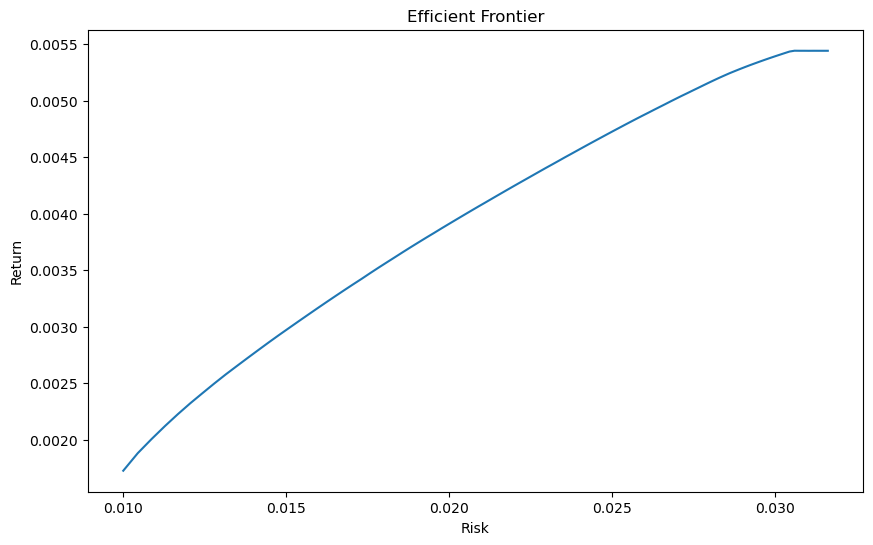

In [269]:
plt.figure(figsize=(10, 6))
plt.plot(np.sqrt(target_variances), target_returns)
plt.xlabel('Risk')
plt.ylabel('Return')
plt.title('Efficient Frontier')
plt.show()